#### Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
from scipy.stats import norm

#### Fetching Data

In [2]:
def fetch_stock_data(ticker="TSLA", period="2y"):
    stock = yf.Ticker(ticker)
    stock_data = stock.history(period=period)
    return stock_data, stock

#### Calculating Necessary metrics

In [3]:
def calculate_metrics(stock_data):
    
    returns = stock_data['Close'].pct_change().dropna()
    mean_return = returns.mean()
    std_dev_return = returns.std()
    
    # Risk-adjusted returns
    risk_free_rate = 0.02  # Assuming 2% annual risk-free rate
    sharpe_ratio = (mean_return - risk_free_rate / 252) / std_dev_return if std_dev_return != 0 else np.nan
    
    # Sortino Ratio (only considers downside volatility)
    downside_returns = returns[returns < 0]
    downside_std_dev = downside_returns.std()
    sortino_ratio = (mean_return - risk_free_rate / 252) / downside_std_dev if downside_std_dev != 0 else np.nan

    # Relative Strength Index (RSI)
    delta = stock_data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))

    # MACD and Signal Line
    ema_12 = stock_data['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = stock_data['Close'].ewm(span=26, adjust=False).mean()
    macd = ema_12 - ema_26
    signal_line = macd.ewm(span=9, adjust=False).mean()

    return {
        'current_price': stock_data['Close'].iloc[-1],
        'fifty_day_ma': stock_data['Close'].rolling(window=50).mean().iloc[-1],
        'two_hundred_day_ma': stock_data['Close'].rolling(window=200).mean().iloc[-1],
        'yearly_high': stock_data['High'].max(),
        'yearly_low': stock_data['Low'].min(),
        'volatility': std_dev_return * np.sqrt(252),
        'daily_return_mean': mean_return,
        'daily_return_std_dev': std_dev_return,
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio,
        'rsi': rsi.iloc[-1],
        'macd': macd.iloc[-1],
        'signal_line': signal_line.iloc[-1],
        'average_volume': stock_data['Volume'].rolling(window=50).mean().iloc[-1]  
    }

#### Calcuate Stock Intrinsic Price

In [4]:
def get_most_recent_fcf(stock):
    cash_flow = stock.cashflow
    if 'Free Cash Flow' not in cash_flow.index:
        raise ValueError("Free Cash Flow data not available for this stock.")
    
    fcf = cash_flow.loc['Free Cash Flow'][0]  # Use the actual FCF without adjustments
    print("\nDEBUG - Annual FCF:", fcf)
    return fcf

def calculate_wacc(stock):
    beta = stock.info.get('beta', 1.5)
    risk_free_rate = 0.035
    market_risk_premium = 0.03
    
    cost_of_equity = risk_free_rate + beta * market_risk_premium
    cost_of_debt = 0.03
    tax_rate = 0.21
    
    equity = stock.info['marketCap']
    debt = stock.info['totalDebt']
    total_capital = equity + debt
    
    if total_capital == 0:
        return cost_of_equity
    
    wacc = (equity / total_capital) * cost_of_equity + \
           (debt / total_capital) * cost_of_debt * (1 - tax_rate)
    
    print("\nDEBUG - WACC Calculation:")
    print(f"Beta: {beta}")
    print(f"Cost of Equity: {cost_of_equity:.4f}")
    print(f"Cost of Debt: {cost_of_debt}")
    print(f"Equity: {equity:,.0f}")
    print(f"Debt: {debt:,.0f}")
    print(f"WACC: {wacc:.4f}")
    
    return wacc

def dcf_valuation(stock):
    try:
        print("\n=== Starting DCF Valuation ===")
        
        # Get initial values
        initial_fcf = get_most_recent_fcf(stock)
        discount_rate = calculate_wacc(stock)
        shares_outstanding = stock.info['sharesOutstanding']
        
        print(f"\nDEBUG - Shares Outstanding: {shares_outstanding:,.0f}")
        
        # Adjusted growth rates for Tesla's profile
        growth_rates = [0.28] * 3 + [0.26] * 3 + [0.24] * 3 + [0.22] * 3 + [0.19] * 3 + [0.16] * 3
        terminal_growth = 0.05  # Adjusted terminal growth rate to 5%
        
        print("\nDEBUG - Growth Assumptions:")
        print(f"Years 1-3: 28%")
        print(f"Years 4-6: 26%")
        print(f"Years 7-9: 24%")
        print(f"Years 10-12: 22%")
        print(f"Years 13-15: 19%")
        print(f"Years 16-18: 16%")
        print(f"Terminal Growth: {terminal_growth:.1%}")
        
        # Project FCFs
        fcf = [initial_fcf]
        for rate in growth_rates:
            fcf.append(fcf[-1] * (1 + rate))
        
        print("\nDEBUG - FCF Projections:")
        for i, value in enumerate(fcf):
            print(f"Year {i}: ${value:,.0f}")
        
        # Calculate terminal value
        terminal_value = fcf[-1] * (1 + terminal_growth) / (discount_rate - terminal_growth)
        print(f"\nDEBUG - Terminal Value: ${terminal_value:,.0f}")
        
        # Calculate present values
        present_value_fcf = sum(cash_flow / (1 + discount_rate) ** i for i, cash_flow in enumerate(fcf[1:], start=1))
        
        present_value_terminal = terminal_value / (1 + discount_rate) ** len(growth_rates)
        
        print("\nDEBUG - Present Values:")
        print(f"PV of FCFs: ${present_value_fcf:,.0f}")
        print(f"PV of Terminal Value: ${present_value_terminal:,.0f}")
        
        # Calculate final values
        dcf_value = present_value_fcf + present_value_terminal
        value_per_share = dcf_value / shares_outstanding
        
        print("\nDEBUG - Final Values:")
        print(f"Total DCF Value: ${dcf_value:,.0f}")
        print(f"Value per Share: ${value_per_share:.2f}")
        
        return {
            'dcf_value': dcf_value,
            'value_per_share': value_per_share,
            'fcf_projections': fcf,
            'discount_rate': discount_rate,
            'terminal_value': terminal_value
        }
     
    except Exception as e:
        print(f"Error in DCF valuation: {e}")
        return None


#### Set Price Target

In [5]:
def generate_price_targets(stock):
    base_valuation = dcf_valuation(stock)
    base_price = base_valuation['value_per_share']
    return {'bull_case': base_price * 1.22, 'base_case': base_price, 'bear_case': base_price * 0.83}

In [6]:
def plot_stock_price_history(stock_data):
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data.index, stock_data['Close'], label='Stock Price')
    plt.plot(stock_data.index, stock_data['Close'].rolling(window=50).mean(), label='50-day MA')
    plt.title('Tesla Stock Price History')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    return plt

#### Generate Report

In [7]:
def generate_report():
    stock_data, stock = fetch_stock_data()
    metrics = calculate_metrics(stock_data)
    valuation = dcf_valuation(stock)
    price_targets = generate_price_targets(stock)


    return f"""
# Tesla (TSLA) Stock Analysis and Valuation Report
**Generated on**: {datetime.now().strftime('%B %d, %Y')}

## 📊 Current Market Metrics
- **Current Price**: ${metrics['current_price']:.2f}
- **50-Day Moving Average**: ${metrics['fifty_day_ma']:.2f}
- **200-Day Moving Average**: ${metrics['two_hundred_day_ma']:.2f}
- **52-Week High**: ${metrics['yearly_high']:.2f}
- **52-Week Low**: ${metrics['yearly_low']:.2f}
- **Historical Volatility**: {metrics['volatility']*100:.1f}%
- **Sharpe Ratio**: {metrics['sharpe_ratio']:.2f}
- **Sortino Ratio**: {metrics['sortino_ratio']:.2f}

## 📈 Technical Indicators
- **RSI (Relative Strength Index)**: {metrics['rsi']:.2f}
- **MACD**: {metrics['macd']:.2f}
- **Signal Line**: {metrics['signal_line']:.2f}
- **Average Trading Volume (50-day)**: {metrics['average_volume']:,.0f} shares

## 📉 Valuation Analysis
### Discounted Cash Flow (DCF) Valuation Summary:
- **Intrinsic Value per Share**: ${valuation['value_per_share']:.2f}
- **Market Price vs. DCF Value**: {('Undervalued' if metrics['current_price'] < valuation['value_per_share'] else 'Overvalued')}

## 📌 Price Targets
- **Bull Case**: ${price_targets['bull_case']:.2f}
- **Base Case**: ${price_targets['base_case']:.2f}
- **Bear Case**: ${price_targets['bear_case']:.2f}

---

📢 **Investment Insight**:  
- Based on the current market metrics, technical indicators, and DCF valuation, Tesla (TSLA) appears to be **{('a potential buy' if metrics['current_price'] < valuation['value_per_share'] else 'potentially overvalued')}**.  
- Investors should watch the RSI and MACD trends for potential entry points.

🚀 *Stay updated and make informed investment decisions!*
"""

In [8]:
def save_report(filename="tesla_analysis_report.md"):
    report = generate_report()
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(report)
    print(f"Report saved as {filename}")


#### Main Function

In [9]:
def main():
    stock_data, stock = fetch_stock_data()
    save_report()
    plt = plot_stock_price_history(stock_data)
    plt.savefig('tesla_price_history.png')



=== Starting DCF Valuation ===


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_60216\3769849241.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fcf = cash_flow.loc['Free Cash Flow'][0]  # Use the actual FCF without adjustments



DEBUG - Annual FCF: 3581000000.0

DEBUG - WACC Calculation:
Beta: 2.336
Cost of Equity: 0.1051
Cost of Debt: 0.03
Equity: 1,086,540,414,976
Debt: 13,623,000,064
WACC: 0.1041

DEBUG - Shares Outstanding: 3,216,519,936

DEBUG - Growth Assumptions:
Years 1-3: 28%
Years 4-6: 26%
Years 7-9: 24%
Years 10-12: 22%
Years 13-15: 19%
Years 16-18: 16%
Terminal Growth: 5.0%

DEBUG - FCF Projections:
Year 0: $3,581,000,000
Year 1: $4,583,680,000
Year 2: $5,867,110,400
Year 3: $7,509,901,312
Year 4: $9,462,475,653
Year 5: $11,922,719,323
Year 6: $15,022,626,347
Year 7: $18,628,056,670
Year 8: $23,098,790,271
Year 9: $28,642,499,936
Year 10: $34,943,849,922
Year 11: $42,631,496,905
Year 12: $52,010,426,224
Year 13: $61,892,407,206
Year 14: $73,651,964,576
Year 15: $87,645,837,845
Year 16: $101,669,171,900
Year 17: $117,936,239,404
Year 18: $136,806,037,709

DEBUG - Terminal Value: $2,656,560,786,969

DEBUG - Present Values:
PV of FCFs: $232,330,325,894
PV of Terminal Value: $447,058,686,633

DEBUG - 

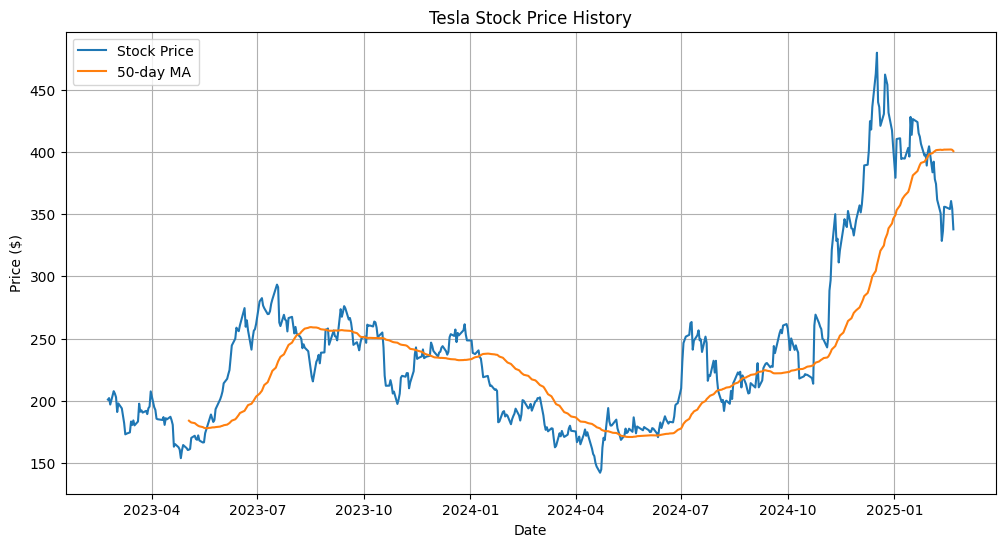

In [10]:
if __name__ == "__main__":
    main()